In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import warnings
from matplotlib.collections import LineCollection
plt.style.use("/Library/Frameworks/Python.framework/versions/3.13/lib/python3.13/site-packages/matplotlib/style/my_style.mplstyle")

In [2]:
def colored_line(x, y, c, ax, **lc_kwargs):
    """
    Plot a line with a color specified along the line by a third value.

    It does this by creating a collection of line segments. Each line segment is
    made up of two straight lines each connecting the current (x, y) point to the
    midpoints of the lines connecting the current point with its two neighbors.
    This creates a smooth line with no gaps between the line segments.

    Parameters
    ----------
    x, y : array-like
        The horizontal and vertical coordinates of the data points.
    c : array-like
        The color values, which should be the same size as x and y.
    ax : Axes
        Axis object on which to plot the colored line.
    **lc_kwargs
        Any additional arguments to pass to matplotlib.collections.LineCollection
        constructor. This should not include the array keyword argument because
        that is set to the color argument. If provided, it will be overridden.

    Returns
    -------
    matplotlib.collections.LineCollection
        The generated line collection representing the colored line.
    """
    if "array" in lc_kwargs:
        warnings.warn('The provided "array" keyword argument will be overridden')

    # Default the capstyle to butt so that the line segments smoothly line up
    default_kwargs = {"capstyle": "butt"}
    default_kwargs.update(lc_kwargs)

    # Compute the midpoints of the line segments. Include the first and last points
    # twice so we don't need any special syntax later to handle them.
    x = np.asarray(x)
    y = np.asarray(y)
    x_midpts = np.hstack((x[0], 0.5 * (x[1:] + x[:-1]), x[-1]))
    y_midpts = np.hstack((y[0], 0.5 * (y[1:] + y[:-1]), y[-1]))

    # Determine the start, middle, and end coordinate pair of each line segment.
    # Use the reshape to add an extra dimension so each pair of points is in its
    # own list. Then concatenate them to create:
    # [
    #   [(x1_start, y1_start), (x1_mid, y1_mid), (x1_end, y1_end)],
    #   [(x2_start, y2_start), (x2_mid, y2_mid), (x2_end, y2_end)],
    #   ...
    # ]
    coord_start = np.column_stack((x_midpts[:-1], y_midpts[:-1]))[:, np.newaxis, :]
    coord_mid = np.column_stack((x, y))[:, np.newaxis, :]
    coord_end = np.column_stack((x_midpts[1:], y_midpts[1:]))[:, np.newaxis, :]
    segments = np.concatenate((coord_start, coord_mid, coord_end), axis=1)

    lc = LineCollection(segments, **default_kwargs)
    lc.set_array(c)  # set the colors of each segment

    return ax.add_collection(lc)


In [285]:
#plotting function
def plot_runs(res, tau_n, n_initial, mu_prime,tau_e_factor, t_final, j, beta, t_eval, nprime):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize = (18,4))
    fig.suptitle(r"$\tau_{n}$=%.1e, $n_{initial}$=%0.2f, $\mu'=%.6e$, $\tau_{e}$=%.0e, $\tau_{n}$/$\tau_{e,scaling}$ = %f" % (tau_n, n_initial, mu_prime, tau_e_factor, tau_n/tau_e_factor))
    #fig.suptitle(r"$\tau_{n}$=%.1e, $n_{initial}$=%0.2f, $\mu'=%.6e$, $\tau_{e}$=%.0e(1-e$^{2}$), $\tau_{n}$/$\tau_{e,scaling}$ = %.2e" % (tau_n, n_initial, mu_prime, tau_e_factor, tau_e_factor/tau_n))

    nth=1

    color = np.linspace(0, t_final, res.t.size)
    lines = colored_line(res.y[2][::nth]*np.cos(res.y[0][::nth]), res.y[2][::nth]*np.sin(res.y[0][::nth]), color/(10**5), ax1, linewidth=1, cmap="plasma",alpha = 1)
    cbar = fig.colorbar(lines, label =r"x$10^{5}$")  # add a color legend


    #e_eq = func_e_eq(tau_e, j, tau_n)

    #sin_phi_eq = func_sin_phi_eq(e_eq,beta, mu_prime,tau_e,n_initial)
    #ax1.scatter(e_eq*np.cos(np.arcsin(sin_phi_eq)), e_eq*sin_phi_eq, color = "black", s = 5, label = "equilibrum")
    ax1.set_xlabel(r"$e\: cos \phi $")
    ax1.set_ylabel(r"$e\: sin \phi $")
    axis_bound = .5
    ax1.set_xlim(-axis_bound,axis_bound)
    ax1.set_ylim(-axis_bound,axis_bound)


    ax2.plot(t_eval/(tau_n*nprime), res.y[1]/nprime, lw = 2) #P_2/P_1 = n/n'. 2 is the outer planet (not evolving)
    ax2.set_xlabel(r"x$10^{%d}$ (x $n'\tau_{n})$" %(int(np.log10(tau_n))))
    ax2.set_ylabel(r"$P_2/P_1$")
    ax2.set_ylim(1.945, 2.1)
    #ax2.set_xlim(0, 1.25)


    ax4.plot(res.t/(tau_n*nprime), res.y[2])
    ax4.set_ylabel("eccentricity")
    ax4.set_xlabel(r"x$10^{%d}$ (x $n'\tau_{n})$" %(int(np.log10(tau_n))))
    #ax4.set_xlim(0, 1.25)
    ax4.set_ylim(0,1)
    
    ax3.plot(res.t/(tau_n*nprime),np.abs(np.sin(res.y[0])))
    #ax3.hlines((sin_phi_eq), 0, max(res.t/(10**5)), color = "black", label = r"$sin{ \phi_{eq}}$")
    #ax3.legend(loc = "upper right")
    ax3.set_xlabel(r"x$10^{%d}$ (x $n'\tau_{n})$" %(int(np.log10(tau_n))))
    ax3.set_ylabel(r"$|sin{\phi}|$")
    #ax3.set_xlim(0, 1.25)
    
    fig.tight_layout()
    plt.show()

In [187]:
#defining the equations
#note that we are encoding [phi, n, e, pomega, lambda] as the array eqns


#equation 1:
def rhs(t, eqns, j, beta, mu_prime, tau_n, tau_e_factor, p, nprime):
    """
    Defines the differential equations .

    Arguments:
        eqns :  vector of the state variables:
                eqns = [phi, n, e, pomega]
        t :  time
        j: order of resonance (j: (j+1))
        beta: defined as 0.8*j. from the disturbing function
        mu_prime: ratio of outer planet mass to star mass
        tau_n: migration timescale
        tau_e: damping timescale
        p: accounts for the contribution of eccentricity damping to changing the mean motion. 3 is used for this paper
        nprime: mean motion of the outer planet
    """
    consts = [j, beta, mu_prime, tau_n, tau_e_factor, p, nprime]

    tau_e = consts[4]#*(1-eqns[2]**2)
    
    pomegadot = -consts[1]*consts[2]*eqns[1]*np.cos(eqns[0])/eqns[2] #pomega is longitude of pericenter

    phidot= (consts[0]+1)*nprime -consts[0]*eqns[1] - pomegadot #φ is a measure of the displacement of the longitude of conjunction from the inner planet’s pericenter.

    ndot = 3*consts[0]*consts[1]*consts[2]*eqns[2]*eqns[1]**2*np.sin(eqns[0])-eqns[1]/consts[3]+(consts[5]*eqns[2]**2*eqns[1]/tau_e) #n is mean motion of pericenter.

    edot = consts[1]*consts[2]*eqns[1]*np.sin(eqns[0])-eqns[2]/tau_e #eccentricity

    lambdadot = eqns[1]

    holder = np.zeros(5) #just doing this so everything is a float
    holder[0] = phidot
    holder[1] = ndot
    holder[2] = edot
    holder[3] = pomegadot
    holder[4] = lambdadot

    return holder


In [205]:
#defining the equations
#note that we are encoding [phi, n, e, pomega, lambda] as the array eqns


#equation 1:
def rhs_nonconst(t, eqns, j, beta, mu_prime, tau_n, tau_e_factor, p, nprime):
    """
    Defines the differential equations .

    Arguments:
        eqns :  vector of the state variables:
                eqns = [phi, n, e, pomega]
        t :  time
        j: order of resonance (j: (j+1))
        beta: defined as 0.8*j. from the disturbing function
        mu_prime: ratio of outer planet mass to star mass
        tau_n: migration timescale
        tau_e: damping timescale
        p: accounts for the contribution of eccentricity damping to changing the mean motion. 3 is used for this paper
        nprime: mean motion of the outer planet
    """
    consts = [j, beta, mu_prime, tau_n, tau_e_factor, p, nprime]

    tau_e = consts[4]*(1-eqns[2]**2)
    #print(tau_e)
    
    pomegadot = -consts[1]*consts[2]*eqns[1]*np.cos(eqns[0])/eqns[2] #pomega is longitude of pericenter

    phidot= (consts[0]+1)*nprime -consts[0]*eqns[1] - pomegadot #φ is a measure of the displacement of the longitude of conjunction from the inner planet’s pericenter.

    ndot = 3*consts[0]*consts[1]*consts[2]*eqns[2]*eqns[1]**2*np.sin(eqns[0])-eqns[1]/consts[3]+(consts[5]*eqns[2]**2*eqns[1]/(consts[4]*(1-eqns[2]**2))) #n is mean motion of pericenter.

    edot = consts[1]*consts[2]*eqns[1]*np.sin(eqns[0])-eqns[2]/(consts[4]*(1-eqns[2]**2)) #eccentricity

    lambdadot = eqns[1]

    holder = np.zeros(5) #just doing this so everything is a float
    holder[0] = phidot
    holder[1] = ndot
    holder[2] = edot
    holder[3] = pomegadot
    holder[4] = lambdadot

    return holder

In [5]:
def func_muprime_min(j,beta,taue_taun):
    muprime_min = j/(np.sqrt(3)*(j+1)**(3/2)*beta)*(taue_taun)**(3/2)
    return muprime_min 

def func_muprime_max(j,beta,taue_taun):
    muprime_max = (j**2/(8*np.sqrt(3)*(j+1)**(3/2)*beta))*(taue_taun)**(3/2)
    return muprime_max

In [6]:
#equilibrium values
def func_e_eq(tau_e, j, tau_n):
    e_eq = (tau_e/(3*(j+1)*tau_n))**.5
    return e_eq

def func_sin_phi_eq(e_eq,beta, mu_prime,tau_e,n_initial):
    sin_phi_eq = e_eq/(beta*mu_prime*tau_e*n_initial)
    return sin_phi_eq

In [7]:
def integration_time(t_initial,t_final, stepsize):
    t_span = (t_initial, t_final)
    number = int(t_final/stepsize)
    #where it is evaluated
    t_eval=np.linspace(t_initial, t_final, num=number)
    return (t_span, t_eval)
    

In [99]:
def integrate(rhs_holder,t_span,initials,t_eval,j,beta,mu_prime,tau_n,tau_e_factor,p,nprime):
    #evaluate
    #atol sets number of correct decimal places
    """To achieve the desired atol set rtol such that rtol * abs(y) is always smaller than atol."""
    res = solve_ivp(rhs_holder, t_span, initials, method='RK45', t_eval=t_eval, dense_output = True, max_step = 1, rtol = 1e-6, args=(j, beta, mu_prime, tau_n, tau_e_factor, p, nprime)) #need integrator to capture small oscillations, not smooth
    print(res.status)
    return res
    

In [15]:
def func_tau_rat_vals(j,beta, mu_prime, number, number_outside):
    tau_ratio_1 = ((mu_prime*np.sqrt(3)*(j+1)**(3/2)*beta)/(j))**(2/3)
    tau_ratio_2 = ((mu_prime*8*np.sqrt(3)*(j+1)**(3/2)*beta)/(j**2))**(2/3)

    tau_span = tau_ratio_2-tau_ratio_1

    t_min = tau_ratio_1 - (number_outside*(tau_span)/number)
    t_max = tau_ratio_2 + (number_outside*(tau_span)/number)

    tau_rat_vals = np.linspace(t_min, t_max, num = number)
    
    return tau_rat_vals

In [301]:
#constants that we literally never change
#define some initial conditions
n_initial = 1.05#somewhat offset from 1, becuase we are doing a 2:1 resonance and we have set nprime to be 1/2 (ie j=1, so (j+1)nprime = 2*nprime = 1 )
phi_initial = 0
e_initial = 0.01
pomega_initial = 0
lambda_initial = 0
initials=  [phi_initial, n_initial, e_initial, pomega_initial, lambda_initial]
#


p=3 #arbitrarily set but can be other values sometimes. Constant throughout integration.
j=1 #2:1 resonance
nprime= 0.5
beta = 0.8*j #disturbing function thing


#integration constants
t_initial = 0
t_final = 1e6
stepsize = 10



#how many tau ratios are we doing:
number = 14
#how many steps on either side outside of the theory lines are we looking at:
number_outside = 2

#constants that we do change sometimes
tau_n=10**5/nprime#migration timescale
#tau_e_scaling= 1e-2 #tau_e_factor/tau_n
mu_prime = 1e-4
#tau_e_factor = tau_e_scaling*tau_n

tau_n_to_tau_e = .6625
tau_e_factor = tau_n/tau_n_to_tau_e

initials_nonconst=  [phi_initial, n_initial, e_initial, pomega_initial, lambda_initial]


#get the ics for all the runs
tau_rat_vals = func_tau_rat_vals(j, beta, mu_prime, number, number_outside)  #gives tau_e/tau_n
print(tau_rat_vals)


t_span = integration_time(t_initial,t_final, stepsize)[0]
t_eval = integration_time(t_initial,t_final, stepsize)[1]


[0.00306026 0.00464925 0.00623823 0.00782722 0.0094162  0.01100518
 0.01259417 0.01418315 0.01577213 0.01736112 0.0189501  0.02053909
 0.02212807 0.02371705]


In [ ]:
for i in range(len(tau_rat_vals)):
    tau_e_factor = tau_rat_vals[i]*tau_n
    res = integrate(rhs, t_span, initials, t_eval,j,beta,mu_prime,tau_n,tau_e_factor,p,nprime)
    plot_runs(res, tau_n, n_initial, mu_prime, tau_e_factor, t_final, j, beta, t_eval, nprime)

In [302]:
print(tau_e_factor)

res = integrate(rhs, t_span, initials, t_eval,j,beta,mu_prime,tau_n,tau_e_factor,p,nprime)
res_nonconstant = integrate(rhs_nonconst, t_span, initials_nonconst, t_eval,j,beta,mu_prime,tau_n,tau_e_factor,p,nprime)


301886.7924528302
0
0


constant


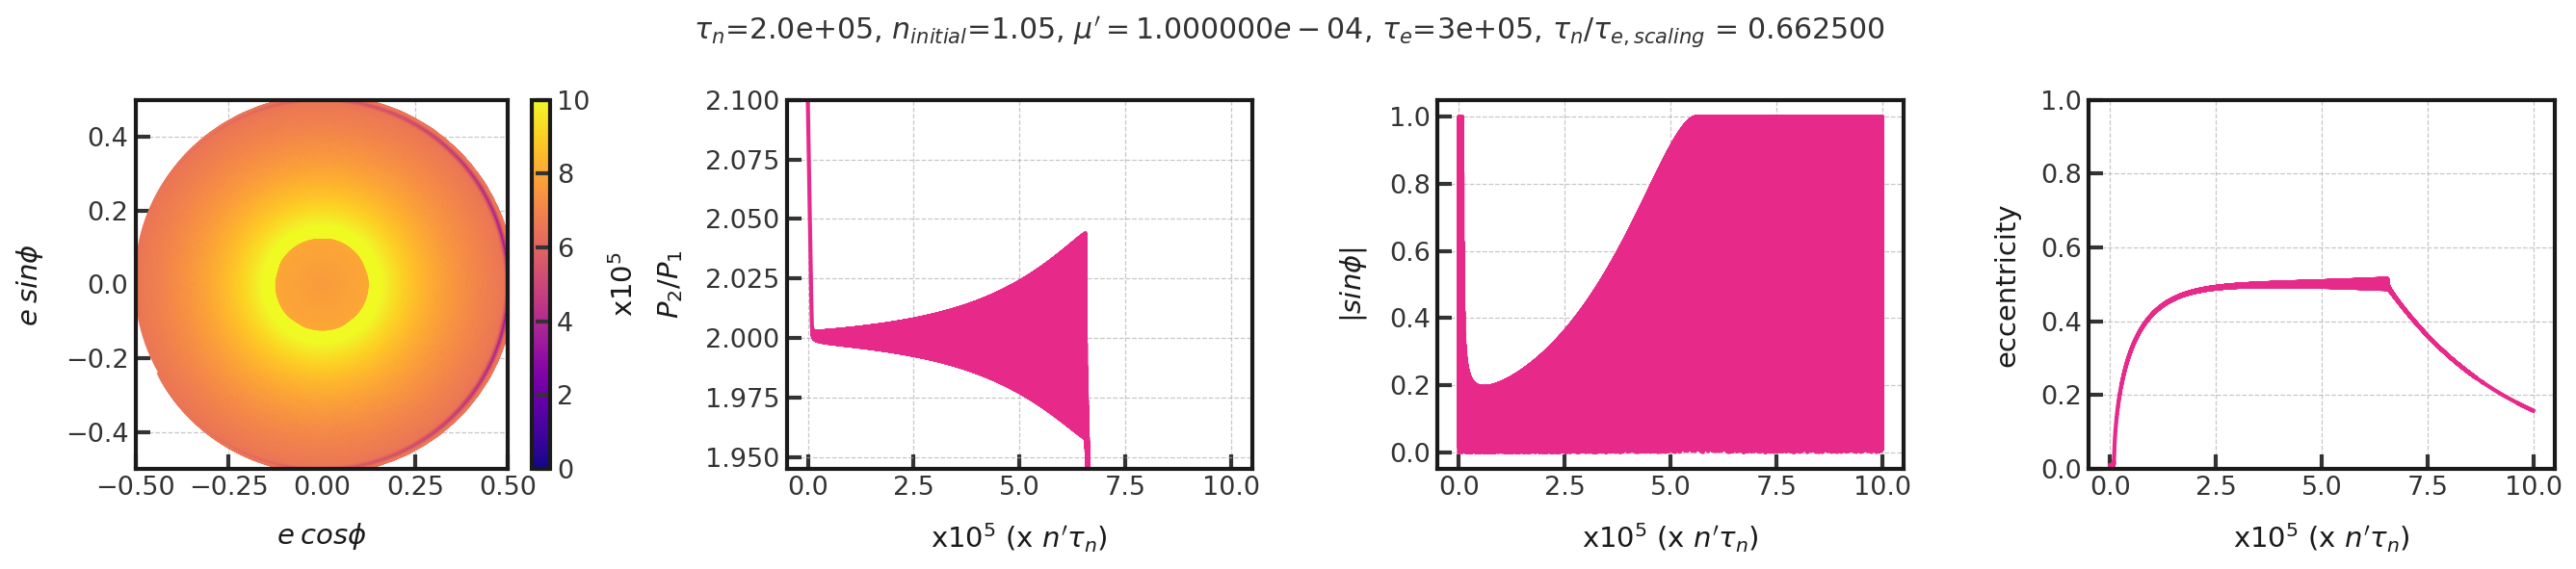

non-constant


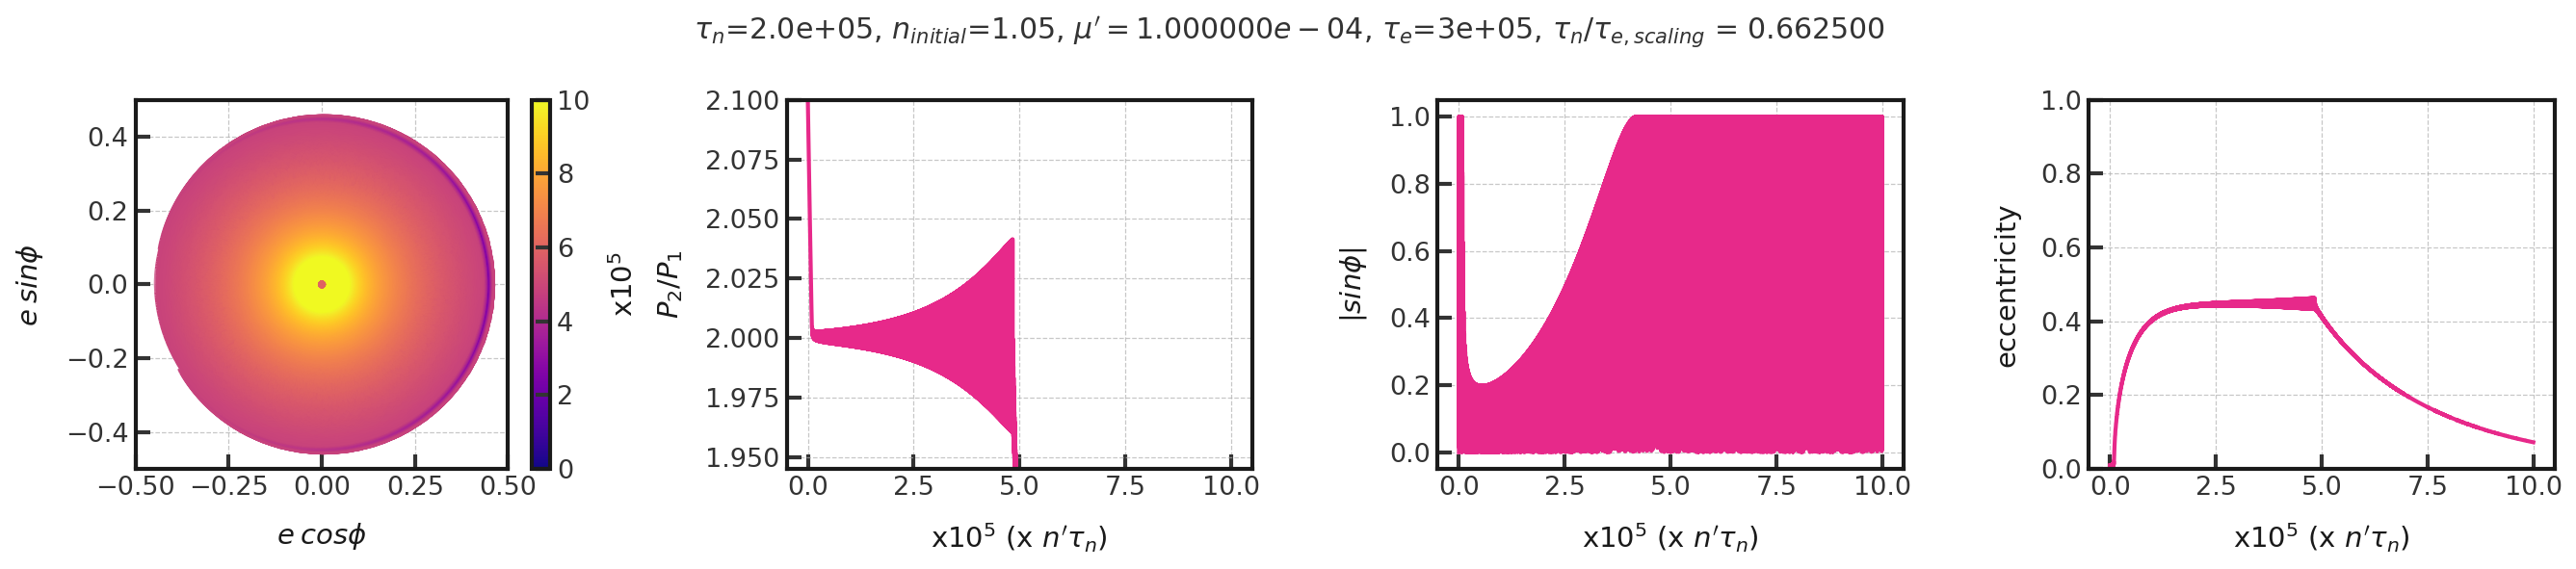

In [303]:
print("constant")
plot_runs(res, tau_n, n_initial, mu_prime, tau_e_factor, t_final, j, beta, t_eval, nprime)
print("non-constant")
plot_runs(res_nonconstant, tau_n, n_initial, mu_prime, tau_e_factor, t_final, j, beta, t_eval, nprime)

Text(0.5, 0, 'time')

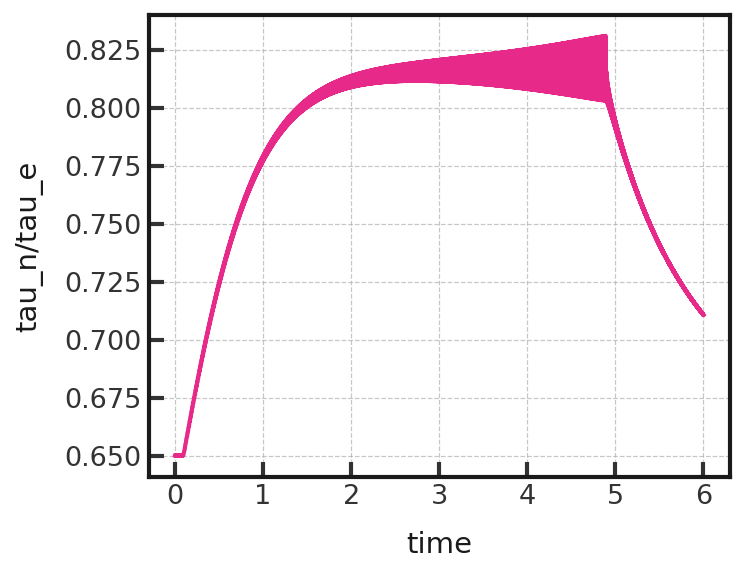

In [294]:
plt.plot(res_nonconstant.t/(tau_n*nprime),tau_n/(tau_e_factor*(1-res_nonconstant.y[2]**2)))
#plt.yscale("log")
plt.ylabel("tau_n/tau_e")
plt.xlabel("time")

Text(0.5, 0, 'time')

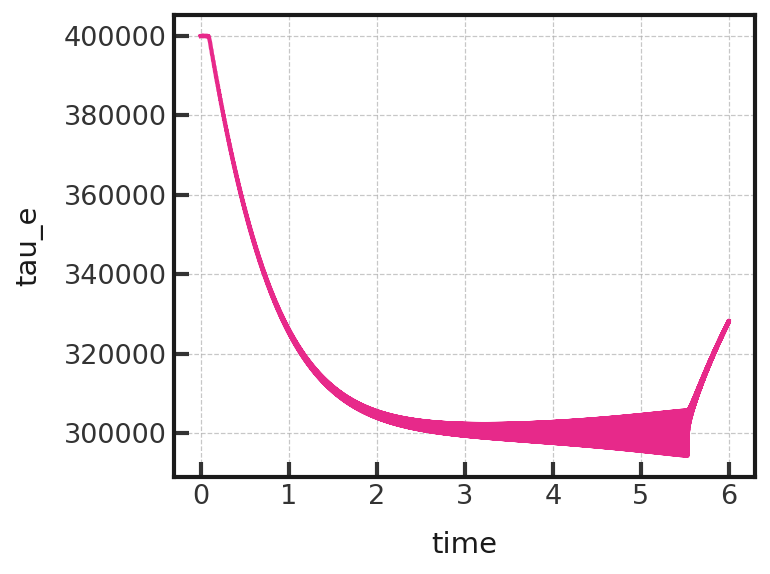

In [288]:
plt.plot(res_nonconstant.t/(tau_n*nprime),(tau_e_factor*(1-res_nonconstant.y[2]**2)))
#plt.yscale("log")
plt.ylabel("tau_e")
plt.xlabel("time")